# K-Nearest Neighbors on Penguin Dataset

This notebook contains the code for a K-Nearest Neighbor (KNN) classifier built using the Palmer Penguin dataset. The dataset is comprised of identifying information about 344 penguins from the Palmer Archipelago, Artarctica, including their physical characteristics, such as culmen length and flipper length, as well as the type of species (Adelie, Chinstrap, or Gentoo). The notebook uses a KNN classifier to identify the species of a penguin based on its culmen length and flipper length. 


#### Dataset Source

Gorman KB, Williams TD, Fraser WR (2014) Ecological Sexual Dimorphism and Environmental Variability within a Community of Antarctic Penguins (Genus Pygoscelis). PLoS ONE 9(3): e90081. doi:10.1371/journal.pone.0090081

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score 

import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

## Read in Data

In [2]:
#read in data
data = pd.read_csv('penguins.csv')

In [3]:
#preview data
data.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


In [4]:
#check shape of dataframe
data.shape

(344, 17)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   studyName            344 non-null    object 
 1   Sample Number        344 non-null    int64  
 2   Species              344 non-null    object 
 3   Region               344 non-null    object 
 4   Island               344 non-null    object 
 5   Stage                344 non-null    object 
 6   Individual ID        344 non-null    object 
 7   Clutch Completion    344 non-null    object 
 8   Date Egg             344 non-null    object 
 9   Culmen Length (mm)   342 non-null    float64
 10  Culmen Depth (mm)    342 non-null    float64
 11  Flipper Length (mm)  342 non-null    float64
 12  Body Mass (g)        342 non-null    float64
 13  Sex                  334 non-null    object 
 14  Delta 15 N (o/oo)    330 non-null    float64
 15  Delta 13 C (o/oo)    331 non-null    flo

In [6]:
data['Species'].value_counts()

Adelie Penguin (Pygoscelis adeliae)          152
Gentoo penguin (Pygoscelis papua)            124
Chinstrap penguin (Pygoscelis antarctica)     68
Name: Species, dtype: int64

<AxesSubplot:>

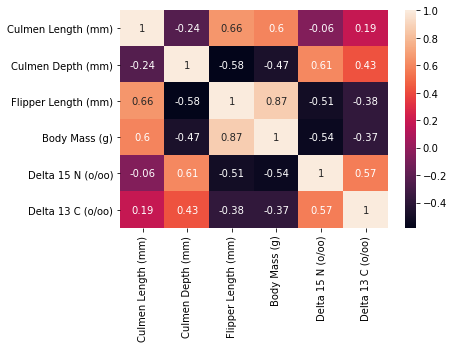

In [7]:
#check correlations between variables
sns.heatmap(data[['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)',
                  'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']].corr(),
            annot = True)

## Clean Data

In [8]:
#keep relevant columns
cols = ['Species', 'Culmen Length (mm)', 'Flipper Length (mm)']

data = data[cols].rename(columns={'Culmen Length (mm)': 'Culmen',
                                  'Flipper Length (mm)': 'Flipper'})

In [9]:
#drop NaN values from dataframe
data = data.dropna().reset_index(drop=True)

#### Convert String Labels to Integers

In [10]:
#encode target values with integers
le = LabelEncoder()
data['Species'] = le.fit_transform(data['Species'])

In [11]:
#dictionary to map species to label
keys = le.classes_
values = le.transform(keys)
species_dict = dict(zip(keys,values))

print(species_dict)

{'Adelie Penguin (Pygoscelis adeliae)': 0, 'Chinstrap penguin (Pygoscelis antarctica)': 1, 'Gentoo penguin (Pygoscelis papua)': 2}


#### Perform Feature Scaling

In [12]:
def normalize_col(df,col):
    '''
    input:  dataframe and column to normalize
    output: normalized column 
    '''
    
    return (df[col] - df[col].min()) / (df[col].max() - df[col].min())

In [13]:
#normalize independent variables
data['Culmen'] = normalize_col(data,'Culmen')
data['Flipper'] = normalize_col(data,'Flipper')

In [14]:
#preview cleaned data
data.head()

,Species,Culmen,Flipper
0,0,0.254545,0.152542
1,0,0.269091,0.237288
2,0,0.298182,0.389831
3,0,0.167273,0.355932
4,0,0.261818,0.305085


## Create Training & Test Datasets

In [15]:
#split data into features and labels
X = data[['Culmen','Flipper']]
y = data['Species']

In [16]:
#set random state for shuffling in dataset split
random_state = 42

In [17]:
#split data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, stratify=y)

In [18]:
print('There are', len(y_train), 'samples in the training set.')

There are 256 samples in the training set.


In [19]:
print('There are', len(y_test), 'samples in the test set.')

There are 86 samples in the test set.


#### Create Dataframes for Visualizing Data

In [20]:
def create_df(X,y):
    '''
    inputs:
        X = dataframe with 'Culmen' and 'Flipper' columns
        y = species label for each penguin
    output: dataframe with columns for culmen length, flipper length, and species
    '''
    df = pd.DataFrame(data={'Culmen': X['Culmen'],
                            'Flipper': X['Flipper'],
                            'Species': y})
    return df

In [21]:
#training data
train_df = create_df(X_train, y_train)

In [22]:
#test data
test_df = create_df(X_test, y_test)

## Plot Training Data

In [23]:
def create_scatter(df, title):
    '''
    inputs:
        df = dataframe to plot
        title = title for scatterplot
    output: scatterplot
    '''
    chart = alt.Chart(df).mark_point().encode(
                x = 'Culmen',
                y = 'Flipper',
                color = 'Species:N').\
            properties(title = title)
    
    return chart

In [24]:
#create scatterplot of training data
train_plot = create_scatter(train_df, 'Penguins in Training Dataset')

In [25]:
#display chart
train_plot

alt.Chart(...)

In [26]:
#scatterplot of training data with fake test point for illustration purposes
point_df = pd.DataFrame(data={'Culmen':[.45], 'Flipper':[.55]})

test_point = alt.Chart(point_df).mark_circle(color='black', size=100).encode(
                 x='Culmen', y='Flipper')

test_point2 = alt.Chart(point_df).mark_circle(color='black', size=3000, opacity=.2).encode(
                  x='Culmen', y='Flipper')

train_plot + test_point + test_point2

alt.LayerChart(...)

## Find Optimal Number of Neighbors Using GridSearchCV

In [27]:
#create KNN classifier
knn = KNeighborsClassifier()

In [28]:
#create list of numbers of neighbors to test
k_list = list(range(1,31,2))
print('The numbers tested for k will be:', k_list)

The numbers tested for k will be: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]


In [29]:
#create grid
params = dict(n_neighbors = k_list)
grid = GridSearchCV(knn, params, cv=10, scoring='accuracy')

In [30]:
#fit grid on data
gs = grid.fit(X_train, y_train)

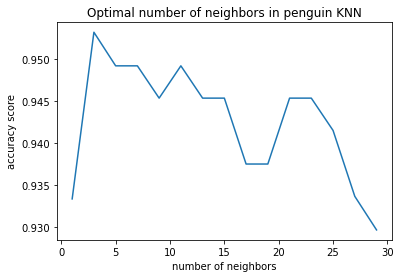

In [31]:
#plot results
plt.plot(k_list,gs.cv_results_['mean_test_score'])
plt.xlabel('number of neighbors')
plt.ylabel('accuracy score')
plt.title('Optimal number of neighbors in penguin KNN')
plt.show()

In [32]:
#find optimal number of neighbors for KNN classifier
n_neigh = gs.best_params_['n_neighbors']
print('The best parameter for n_neighbors is:',n_neigh)

The best parameter for n_neighbors is: 3


In [33]:
print('The highest accuracy is:', gs.best_score_)

The highest accuracy is: 0.9532307692307693


## Train KNN Classifier

In [34]:
#fit KNN on training data
knn = KNeighborsClassifier(n_neighbors=n_neigh)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [35]:
#predict labels for testing data using KNN classifier
labels = knn.predict(X_test)

In [36]:
#create dataframe using predicted species labels
pred_df = create_df(X_test, labels)

In [37]:
#preview data with predicted labels
pred_df.head()

,Culmen,Flipper,Species
52,0.360000,0.474576,0
48,0.370909,0.322034,0
220,0.650909,0.983051,2
316,0.538182,0.847458,2
92,0.272727,0.237288,0


In [38]:
#preview data with actual labels
test_df.head()

,Culmen,Flipper,Species
52,0.360000,0.474576,0
48,0.370909,0.322034,0
220,0.650909,0.983051,2
316,0.538182,0.847458,2
92,0.272727,0.237288,0


## Plot Test Data

#### Plot Decision Boundaries

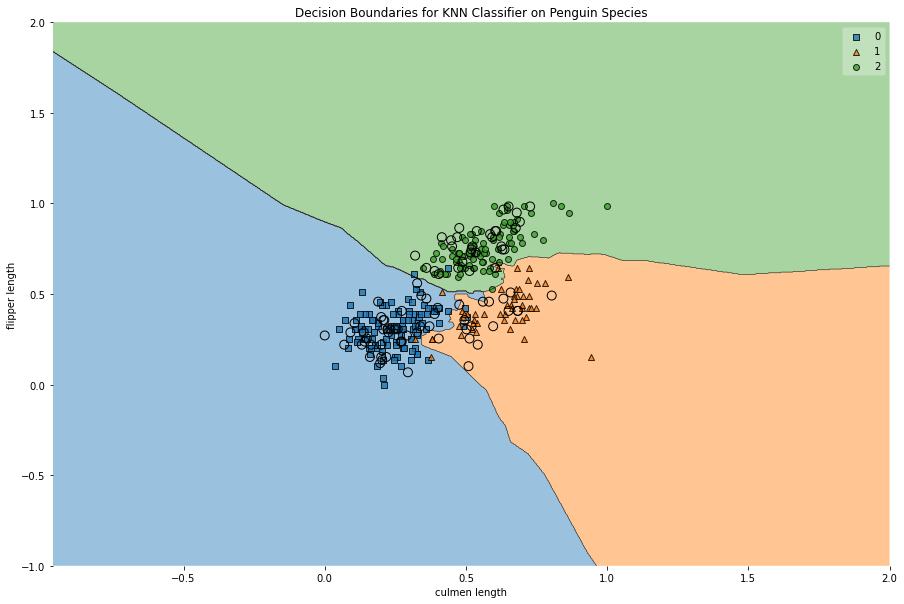

In [39]:
#set size of plot
plt.figure(figsize=(15,10))

#plot decision boundaries
plot_decision_regions(X = np.asarray(X_train),
                      y = np.asarray(y_train),
                      clf=knn,
                      X_highlight = np.asarray(X_test))

#annotate plot
plt.xlabel('culmen length')
plt.ylabel('flipper length')
plt.title('Decision Boundaries for KNN Classifier on Penguin Species')

#display plot
plt.show()

In [40]:
#create scatterplot of predicted labels for test data
pred_plot = create_scatter(pred_df, 'Predicted Species of Penguins in Test Dataset')

In [41]:
#create scatterplot of actual labels for test data
test_plot = create_scatter(test_df, 'Actual Species of Penguins in Test Dataset')

In [42]:
pred_plot | test_plot

alt.HConcatChart(...)

In [43]:
wrong_df = pred_df[pred_df['Species']!=test_df['Species']]

In [44]:
wrong_plot = alt.Chart(wrong_df).mark_circle(size=200, opacity=0.3).encode(
                 x = 'Culmen',
                 y = 'Flipper',
                 color = 'Species:N')

In [45]:
test_plot + wrong_plot

alt.LayerChart(...)

## Test Performance of the Classifier

In [46]:
cm = confusion_matrix(y_test, labels)
cm

array([[38,  0,  0],
       [ 1, 16,  0],
       [ 0,  0, 31]])

In [47]:
print ("Accuracy:", accuracy_score(y_test, labels))

Accuracy: 0.9883720930232558
